Molecular dynamics is the study of how molecules move, what forces affect them, and how their movement and the forces interact. Experiments have found certain rules to this. For example:

* The force affecting molecules is equal to the negative gradient of their potential energy
* The potential of molecules is dependent on their velocity and temperature
* When molecules collide, they transfer energy

Computer programs are often used to study molecular dynamics. There are a wide variety of existing ones that can be used as a basis for a new program. In this case, the program created on the blog NZNano was used for the physics of the molecular dynamics, with the output modified by myself. Only the plot function and the cell it is in are my own work.

In [1]:
import numpy as np
import sympy as sp
import matplotlib
import matplotlib.pyplot as plt
import math as mat


sp.init_session(quiet = True)
%matplotlib inline

In [28]:
#Note, for this program to function, the number of particles N must be less than the time simulated NSteps

The following two functions are used for the MD loop to calculate the force on the simulated molecules and the temperature of the simulated molecules, respectively. 

In [56]:
def Compute_Forces(pos,acc,ene_pot,epsilon,BoxSize,DIM,N):
    # Compute forces on positions using the Lennard-Jones potential
    # Uses double nested loop which is slow O(N^2) time unsuitable for large systems
    Sij = np.zeros(DIM) # Box scaled units
    Rij = np.zeros(DIM) # Real space units
    
    #Set all variables to zero
    ene_pot = ene_pot*0.0
    acc = acc*0.0
    virial=0.0
    
    # Loop over all pairs of particles
    for i in range(N-1):
        for j in range(i+1,N): #i+1 to N ensures we do not double count
            Sij = pos[i,:]-pos[j,:] # Distance in box scaled units
            for l in range(DIM): # Periodic interactions
                if (np.abs(Sij[l])>0.5):
                    Sij[l] = Sij[l] - np.copysign(1.0,Sij[l]) # If distance is greater than 0.5  (scaled units) then subtract 0.5 to find periodic interaction distance.
            
            Rij = BoxSize*Sij # Scale the box to the real units in this case reduced LJ units
            Rsqij = np.dot(Rij,Rij) # Calculate the square of the distance
            
            if(Rsqij < Rcutoff**2):
                # Calculate LJ potential inside cutoff
                # We calculate parts of the LJ potential at a time to improve the efficieny of the computation (most important for compiled code)
                rm2 = 1.0/Rsqij # 1/r^2
                rm6 = rm2**3.0 # 1/r^6
                rm12 = rm6**2.0 # 1/r^12
                phi = epsilon*(4.0*(rm12-rm6)-phicutoff) # 4[1/r^12 - 1/r^6] - phi(Rc) - we are using the shifted LJ potential
                # The following is dphi = -(1/r)(dV/dr)
                dphi = epsilon*24.0*rm2*(2.0*rm12-rm6) # 24[2/r^14 - 1/r^8]
                ene_pot[i] = ene_pot[i]+0.5*phi # Accumulate energy
                ene_pot[j] = ene_pot[j]+0.5*phi # Accumulate energy
                virial = virial - dphi*Rsqij # Virial is needed to calculate the pressure
                acc[i,:] = acc[i,:]+dphi*Sij # Accumulate forces
                acc[j,:] = acc[j,:]-dphi*Sij # (Fji=-Fij)
    return acc, np.sum(ene_pot)/N, -virial/DIM # return the acceleration vector, potential energy and virial coefficient

In [57]:
def Calculate_Temperature(vel,BoxSize,DIM,N):
    
    ene_kin = 0.0
    
    for i in range(N):
        real_vel = BoxSize*vel[i,:]
        ene_kin = ene_kin + 0.5*np.dot(real_vel,real_vel)
    
    ene_kin_aver = 1.0*ene_kin/N
    temperature = 2.0*ene_kin_aver/DIM
    
    return ene_kin_aver,temperature
    

Once the two secondary functions are set up, the variables are created. Many of these are based off the properties and behavior of real molecules, however, three notable exceptions are `N`, the number of molecules, `BoxSize`, the length of a side of the simulated region of space, and `pos`, which is used to set the inital starting positions of the molecules.

In [58]:
r = np.linspace(0.01,3.0,num=500) # Make a radius vector
epsilon = 1 # Energy minimum
sigma = 1 # Distance to zero crossing point
E_LJ = 4*epsilon*((sigma/r)**12-(sigma/r)**6) # Lennard-Jones potential



# The cutoff and shifting value
Rcutoff = 2.5
phicutoff = 4.0/(Rcutoff**12)-4.0/(Rcutoff**6) # Shifts the potential so at the cutoff the potential goes to zero

E_LJ_shift = E_LJ - phicutoff # Subtract the value of the potential at r=2.5

DIM = 2 #Dimensions
N = 25

BoxSize = 100.0  #6.35 

volume  = BoxSize**DIM
density = N / volume
#print("volume = ", volume, " density = ", density)

pos = np.zeros([N,DIM])
        

pos = pos[:,:DIM]/BoxSize
#print(pos)

MassCentre = np.sum(pos,axis=0)/N

for i in range(DIM):
    pos[:,i] = pos[:,i]-MassCentre[i]


A final few parameters are added, most notably `NSteps`. This variable is the equivalent of time for this simulation, and determines the number of times the MD loop runs. The loop returns a list of all velocities for each rendition of the loop in a list of lists `VelOutput`

In [59]:
# Setting up the simulation
NSteps=1000 # Number of steps
deltat = 0.0032 # Time step in reduced time units
TRequested = 0.5# #Reduced temperature
DumpFreq = 100 # Save the position to file every DumpFreq steps
epsilon = 1.0 # LJ parameter for the energy between particles

# Main MD loop
def main(pos,NSteps,deltat,TRequested,DumpFreq,epsilon,BoxSize,DIM):
    
    # Vectors to store parameter values at each step
    N = np.size(pos[:,1])
    ene_kin_aver = np.ones(NSteps)
    ene_pot_aver = np.ones(NSteps)
    temperature = np.ones(NSteps)
    virial = np.ones(NSteps)
    pressure = np.ones(NSteps)
    ene_pot = np.ones(N)

    vel = (np.random.randn(N,DIM)-0.5)
    acc = (np.random.randn(N,DIM)-0.5)
    
    velOutput = [] #This is something I added to the original code

    
    
    
    for k in range(NSteps):
        
        velOutput.append(vel) #This is also something I added to the original code
        
        # Refold positions according to periodic boundary conditions
        for i in range(DIM):
            period = np.where(pos[:,i] > 0.5)
            #period = 0
            pos[period,i]=pos[period,i]-1.0
            period = np.where(pos[:,i] < -0.5)
            pos[period,i]=pos[period,i]+1.0

        # r(t+dt) modify positions according to velocity and acceleration
        pos = pos + deltat*vel + 0.5*(deltat**2.0)*acc # Step 1

        # Calculate temperature
        ene_kin_aver[k],temperature[k] = Calculate_Temperature(vel,BoxSize,DIM,N)

        # Rescale velocities and take half step
        chi = np.sqrt(TRequested/temperature[k])
        vel = chi*vel + 0.5*deltat*acc # v(t+dt/2) Step 2

        # Compute forces a(t+dt),ene_pot,virial
        acc, ene_pot_aver[k], virial[k] = Compute_Forces(pos,acc,ene_pot,epsilon,BoxSize,DIM,N) # Step 3

        # Complete the velocity step 
        vel = vel + 0.5*deltat*acc # v(t+dt/2) Step 4

        # Calculate temperature
        ene_kin_aver[k],temperature[k] = Calculate_Temperature(vel,BoxSize,DIM,N)

        # Calculate pressure
        pressure[k]= density*temperature[k] + virial[k]/volume
        #print(ene_kin_aver)

    #print(vel)
        
    
    return velOutput



In [60]:
velOutput =main(pos,NSteps,deltat,TRequested,DumpFreq,epsilon,BoxSize,DIM)

The function is run, while the `plot` function is used to create a series of subplots for each particle, showing it's velocity in both the x and y directions across time. Due to the initial random velocities, these graphs tend to be wildly divergent from each other. 

`VelOutput` is split into two lists of lists, one inner list per particle per direction. These two lists contain separate lists for each particle. 

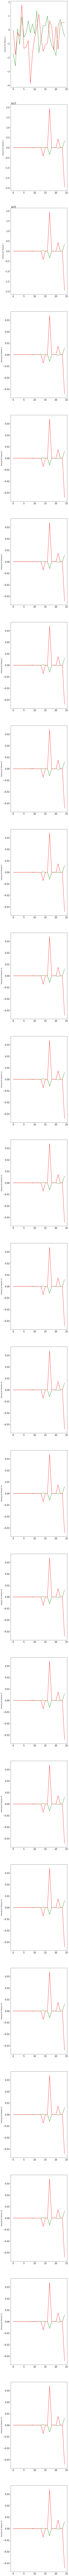

In [61]:
def plot(velX,velY):
   
    #This function is all mine
    n = len(velX)
    #nIntervals = mat.floor(n/10)+1
    
    plt.figure(figsize=[7,12])
    plt.rc('xtick', labelsize=15) 
    plt.rc('ytick', labelsize=15)
    plt.subplots_adjust(top= 21.50)
    
    for i in range(0,n):
        #print(i)
        plt.subplot(n+1,1,i+1)
        #print(velX[i][0])
        plt.plot(velX[i],'g-', data = "X-Velocity")
        plt.plot(velY[i], "r-", data= "Y-Velocity")
        plt.ylabel("Velocity for Particle " + str(i+1), fontsize=10)
    
    plt.show()



#print(temperature)

#print(velInit)

yVelList = []
xVelList = []

for i in range(0,N):
    xVelList.append([])
    yVelList.append([])

    
for i in range(0,N):
    #print(i)
    #print(velOutput[i])
    for j in velOutput[i]:
        xVelList[i].append(j[0])
        yVelList[i].append(j[1])
    #print(xVelList)
    #print(velOutput[i])

    
    
#for i in range(5):    
    #print(velOutput[i])    
#print(xVelList)
velX = np.array(xVelList)
velY = np.array(yVelList)
#print(velX)
#print(velX[1])
#print(velX[7])
#for i in velOutput:
    #print(i[0])
#print(vel[1][1])    

#print(vel)
#print(velX)

plot(velX,velY)